In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint
from itertools import permutations
from math import exp, ceil
from numpy import linspace, nanmax, nanmin
from matplotlib import cm

## In a closed population, at the beginning of season _t_, what is the expected titer _Ti_ of a random individual against a virus of genotype _i_?

As we are ultimately interested in understanding the incidence of DHF in a given season as a function of the population immunity, we consider only individuals who have had a primary infection, but not a secondary infection. On average, 5-6 years elapse between primary and secondary infections. We assume the incidence of primary and secondary infections are approximately equal to each other and across seasons, and treat the population as closed.

In this case, _Ti_ is dependent on:  
* What genotypes, _j(i -> n)_ have people most likely been exposed to?  
* How long ago where they exposed?  
* How antigenically similar are genotypes _i_ and _j_? 

Thus, we parameterize _Ti_ as a simple function of genotype frequencies and titer measurements.  

In [3]:
# Pull pre-computed genotype frequencies
genotype_frequencies = pd.read_csv('../../../data/frequencies/southeast_asia_frequencies.csv', index_col=0) 
serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']

In [4]:
# Bin seasons by the midpoint of each year (consistent with data collection @ Nicaraguan cohort study)
seasons = [(t+0.5, t+1.5) for t in range(1980, 2015)]

# Bin each pivot from augur (row in frequencies data) by which season it falls into. Average frequencies by season.
def bin_seasons(df, seasons=seasons):
    def find_season(date, seasons=seasons):
        season = np.nan
        for (start,end) in seasons:
            if date >= start and date < end:
                season = (start,end)
                break
        return season
    df['season'] = [find_season(date, seasons) for date in df.index.values]
    df.dropna(how='any', inplace=True)
    df = df.groupby('season').agg('mean')
    return df

# serotype_frequencies = bin_seasons(serotype_frequencies, seasons)
genotype_frequencies = bin_seasons(genotype_frequencies, seasons)

print genotype_frequencies.head()

                   DENV1_I  DENV1_II  DENV1_IV  DENV1_V  DENV2_ASIANAMERICAN  \
season                                                                         
(1980.5, 1981.5)  0.181783  0.001283  0.009092      0.0             0.115975   
(1981.5, 1982.5)  0.174983  0.001108  0.008375      0.0             0.113783   
(1982.5, 1983.5)  0.148933  0.000933  0.007500      0.0             0.133433   
(1983.5, 1984.5)  0.132792  0.000925  0.007458      0.0             0.147625   
(1984.5, 1985.5)  0.129933  0.001050  0.008158      0.0             0.136592   

                  DENV2_ASIANI  DENV2_COSMOPOLITAN  DENV2_SYLVATIC   DENV3_I  \
season                                                                         
(1980.5, 1981.5)      0.137575            0.027192        0.001892  0.070650   
(1981.5, 1982.5)      0.135700            0.023808        0.001633  0.085383   
(1982.5, 1983.5)      0.159933            0.023667        0.001675  0.088625   
(1983.5, 1984.5)      0.177250         

In [5]:
# Pull pre-computed average autologous-value-normalized log2 titer values
# for each (virus genotype, serum genotype) pair.
# Missing values are filled with (virus genotype, serum SEROtype) when possible
genotype_titers = pd.read_csv('../../../data/katzelnick2015/processed/genotypes_normalized_filled.csv', header=None, names=['virus_genotype', 'serum_genotype', 'titer'])

# for now, just work with the genotypes we have data for
virus_gt = set(genotype_titers['virus_genotype'].values)
serum_gt = set(genotype_titers['serum_genotype'].values)
freqs_gt = set(genotype_frequencies.columns.values)
genotypes = sorted(list(virus_gt & serum_gt & freqs_gt))
genotypes = [g for g in genotypes if 'SYLVATIC' not in g]

# pivot to multiindex for pairwise indexing
genotype_titers = genotype_titers.set_index(['virus_genotype', 'serum_genotype'])

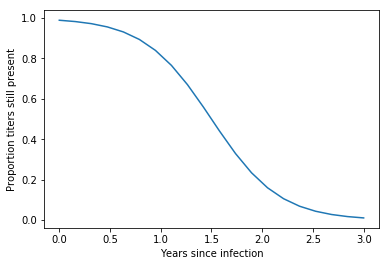

In [6]:
#### Model the waning of cross-protective immunity
def gamma(s):
    ''' 
    model immunity as waning according to a 
    sigmoid-y function dependent on s, the number of 
    seasons in the past that the primary infection 
    occurred'''
    g_s = 1./(1.+exp(3.*(s-1.5)))
    return g_s

plt.plot([x for x in linspace(0,3,num=20)], [gamma(x) for x in linspace(0,3,num=20)])
plt.xlabel('Years since infection')
plt.ylabel('Proportion titers still present')

In [23]:
#### Frequencies of genotype j
def x_j_t(j, t_s, x = genotype_frequencies):
    ''' return the frequency (x) of genotype j at time t_s'''
    return x[j][t_s]

#### Titers for virus i, serum j
def T_i_j(i,j):
    ''' return the average titer of virus i against sera j'''
    try:
        return genotype_titers.ix[(i,j)].values[0]
    except KeyError as e:
        j_sero = j[:5]
        igeno_jsero = [(I,J) for (I,J) in genotype_titers.index.values if I==i and J.startswith(j_sero)]
        return genotype_titers.loc[igeno_jsero].mean().values[0]

#### Sum over genotypes
def sum_genotypes(i,t_s,genotypes=genotypes):
    ''' sum together (antigenic distance between i and j) * (frequency of j @ time t-s) for each genotype j '''
    return sum([ T_i_j(i,j) * x_j_t(j,t_s) for j in genotypes])

#### Sum over past seasons, (t-s -> s)
def double_counting_correction(t_s, s, seasons=genotype_frequencies.index.values):
    ## Account for "double-counting" of seasons by dividing by a factor of [1,2,3,4,S,S,S,...S-1, S-2,...1]
    
    double_counted = [s for s in range(len(seasons))]
    double_counted[:s] = range(1,s+1)
    double_counted[-s:] = reversed(range(1,s+1))

    season_number = list(seasons).index(t_s)
    return 1.0*double_counted[season_number]

def sum_seasons(i, t, s):
    ''' 
    sum over previous seasons, t-s: 
        gamma(s)*[ for each j: (antigenic distance between i and j)*(frequency of j at time t-s)]'''
    relevant_t_s = [(t[0]-s, t[1]-s) for s in range(s)] # past seasons, t_s       
    return sum([ (gamma(s) * sum_genotypes(i,t_s))/double_counting_correction(t_s, s)
                for s,t_s in enumerate(relevant_t_s)])

#### Run
def calc_expected_titers(i, seasons_back, seasons=seasons):
    ''' Calculate expected titers at the start of each season we have data for '''
    starting_seasons = seasons[seasons_back+1:]
    T_i = [sum_seasons(i,t,seasons_back) for N,t in enumerate(starting_seasons)]
    return pd.Series(T_i)

In [25]:
valid_genotypes = [g for g in genotypes if genotype_frequencies[g].max() >= 0.05]
expected_titers = {g: calc_expected_titers(g,5) for g in valid_genotypes}
all_titers = []
for v in expected_titers.values():
    all_titers += v.tolist()
max_expected_titer = nanmax(all_titers)
min_expected_titer = nanmin(all_titers)

In [56]:
#### Plot

def plot_Ti_frequencies(i, seasons_back, ax, **kwargs):
    
    if seasons_back == 5:
        x = expected_titers[i]
    else:
        x = calc_expected_titers(i, seasons_back)
    y = pd.Series(list(genotype_frequencies[i][seasons_back+1:]), dtype=np.float64)
    
    sns.regplot(x,y, ax=ax)
    ax.set_title(i)
    ax.set_xlabel('Expected titer against %s'%i)
    ax.set_ylabel('Frequency of %s'%i)    
    ax.set_ylim(bottom=0.)
    
    
def plot_Ti_delta_frequencies(i, seasons_back, ax, seasons_forward=3, **kwargs):
    
    if seasons_back == 5:
        x = pd.Series(expected_titers[i])
    else:
        x = pd.Series(calc_expected_titers(i, seasons_back))
    
    s2 = list(genotype_frequencies[i][seasons_back+1:])
    s1 = list(genotype_frequencies[i][:-1*seasons_forward])
    delta_f = pd.Series([S2-S1 for (S2, S1) in zip(s2, s1)])

    sns.regplot(x,delta_f, ax=ax)
    ax.set_title(i)
    ax.set_xlabel('Expected titer against %s'%i)
    ax.set_ylabel('%d-yr change in %s frequency'%(seasons_forward, i))

    
def plot_time_frequencies_Ti(i, seasons_back, ax, **kwargs):
    
    x = [s[0] for s in seasons[seasons_back+1:]]
    y = list(genotype_frequencies[i][seasons_back+1:].values)
    
    if seasons_back == 5:
        T_i = expected_titers[i]
    else:
        T_i = calc_expected_titers(i, seasons_back)
        
    normed_T_i = [ t/(2*max_expected_titer)+0.25 for t in T_i ] #restrict colors to [0.25, 0.75] range of the cmap
        
    c = [cm.autumn_r(t) for t in normed_T_i]
    ax.plot(x,y,'-', c='gray')
    ax.scatter(x,y,c=c, zorder=5, s=20)
    
    ax.set_title(i)
    ax.set_xlabel('Season')
    ax.set_ylabel('Genotype Frequency')
    ax.set_ylim(0,0.3)

In [49]:
def plot_all_genotypes(plot_fn, seasons_back, genotypes=genotypes, **kwargs):
    
    valid_genotypes = [g for g in genotypes if genotype_frequencies[g].max() >= 0.05]
    
    ncols = 4
    nrows = int(ceil(len(valid_genotypes)/ncols))
    
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, figsize=(12,8), sharey=True, sharex=True)
    
    for genotype, ax in zip(valid_genotypes, axes.flatten()):
        try:
            plot_fn(genotype, seasons_back, ax, **kwargs)
        except ValueError:
            continue
    
    if 'title' in kwargs:
        plt.suptitle(kwargs['title'], va='bottom', size=12)
        
    if 'colorbar' in kwargs and kwargs['colorbar'] == True:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        
        fig.colorbar(im, cax=cbar_ax)

    plt.tight_layout()
    plt.show()

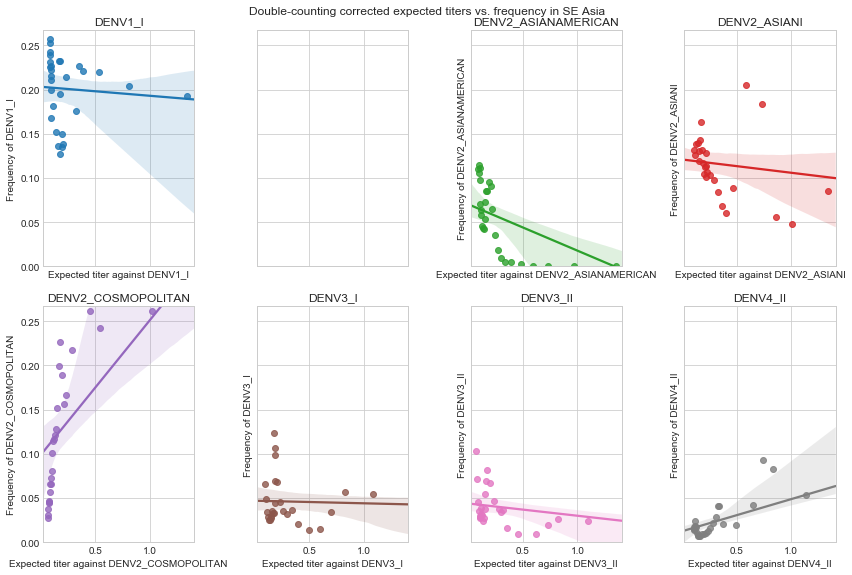

In [52]:
plot_all_genotypes(plot_Ti_frequencies, 5, title='Double-counting corrected expected titers vs. frequency in SE Asia')

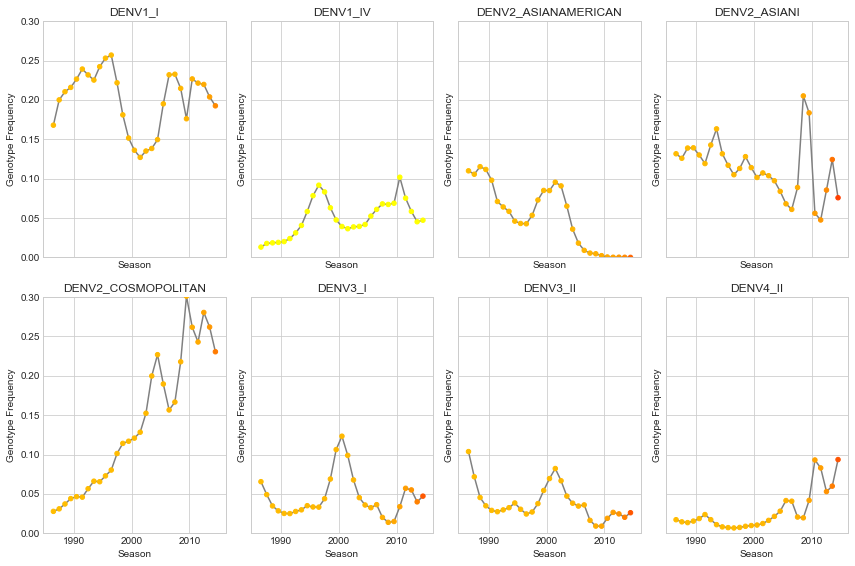

In [57]:
plot_all_genotypes(plot_time_frequencies_Ti, 5)